# Combining misaligned spectra

*gully* and *Aishwarya*  
November 12, 2021

In [a previous tutorial](https://muler.readthedocs.io/en/latest/tutorials/Combining_uncertainties_with_specutils.html) we saw how to combine spectra that are aligned.  Here we show a new way to combine misaligned spectra.

In [1]:
from muler.hpf import HPFSpectrum
#from gollum.phoenix import PHOENIXSpectrum
import astropy.units as u
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

We'll conduct the same steps as we did in [our previous tutorial on masking](https://muler.readthedocs.io/en/latest/tutorials/Masking_and_flattening.html).

In [3]:
import glob

In [4]:
fns = glob.glob('../../../muler_example_data/HPF/01_A0V_standards/Goldilocks_*.spectra.fits')

In [5]:
n_spectra = len(fns)

In [6]:
multi_spectra = []
for fn in fns:
    raw_spectrum = HPFSpectrum(file = fn, order=6)
    multi_spectra.append(raw_spectrum)

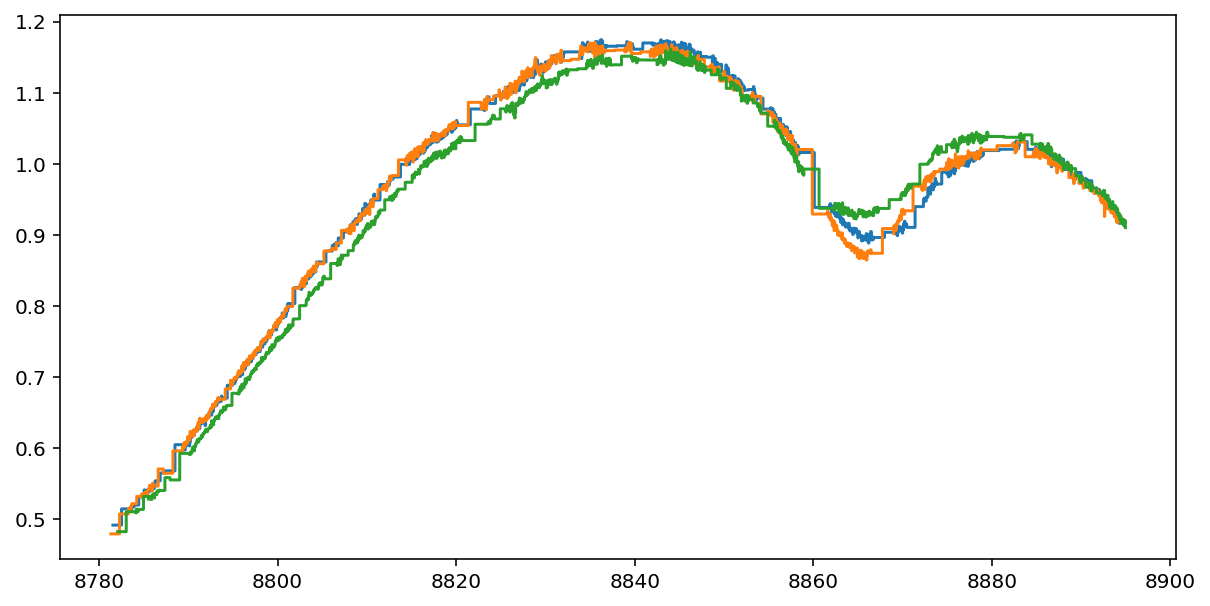

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 5))
clean_multi_spec = []
for i in range(n_spectra):
    clean_spectrum = multi_spectra[i]\
        .trim_edges((4, 2042))\
        .normalize()\
        .mask_tellurics()\
        .barycentric_correct()
    clean_spectrum.plot(ax) #plot singular spectra
    clean_multi_spec.append(clean_spectrum) #save all clean spectra in list

Awesome! We have three spectra we want to combine, *but* the spectra are not aligned! What do we do?

In [8]:
from scipy.stats import binned_statistic

In [9]:
x = [spectrum.wavelength.value for spectrum in clean_multi_spec] #call attribute wavelength for each spectra in list 
y = [spectrum.flux.value for spectrum in clean_multi_spec] #call attribute flux for each spectra in list 
#note: x has units Angstrom, value removes units

In [10]:
x = np.hstack(x) #stacks list horizontally for each spectra
y = np.hstack(y)

In [11]:
bins = multi_spectra[0].wavelength.value
wavelength_unit = clean_multi_spec[0].wavelength.unit #Angstrom
flux_unit = clean_multi_spec[0].flux.unit #dimensionless

In [12]:
result = binned_statistic(x=x,values=y,statistic='mean',bins=bins) #gives combined spectrum

In [13]:
bin_sizes = bins[1:]-bins[0:-1] #right edge minus left edge
wavelength_out = bins[0:-1]+bin_sizes/2 #half of bin to get center

combined_flux = result.statistic

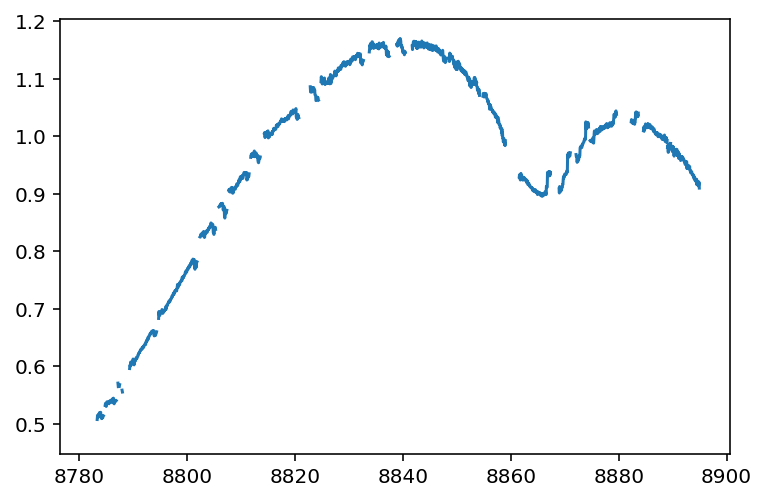

In [14]:
plt.plot(wavelength_out,combined_flux) #gaps are telluric corrections
#statistic gives mean object for y value

In [15]:
combined_spectrum = HPFSpectrum(spectral_axis=wavelength_out*wavelength_unit,flux=combined_flux*flux_unit)

<Spectrum1D(flux=<Quantity [nan, nan, nan, ..., nan, nan, nan]>, spectral_axis=<SpectralAxis [8781.67308395, 8781.73767367, 8781.80225525, ..., 8894.99745326,
   8895.0432421 , 8895.08902103] Angstrom>)>

<AxesSubplot:title={'center':'HPF Spectrum'}, xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

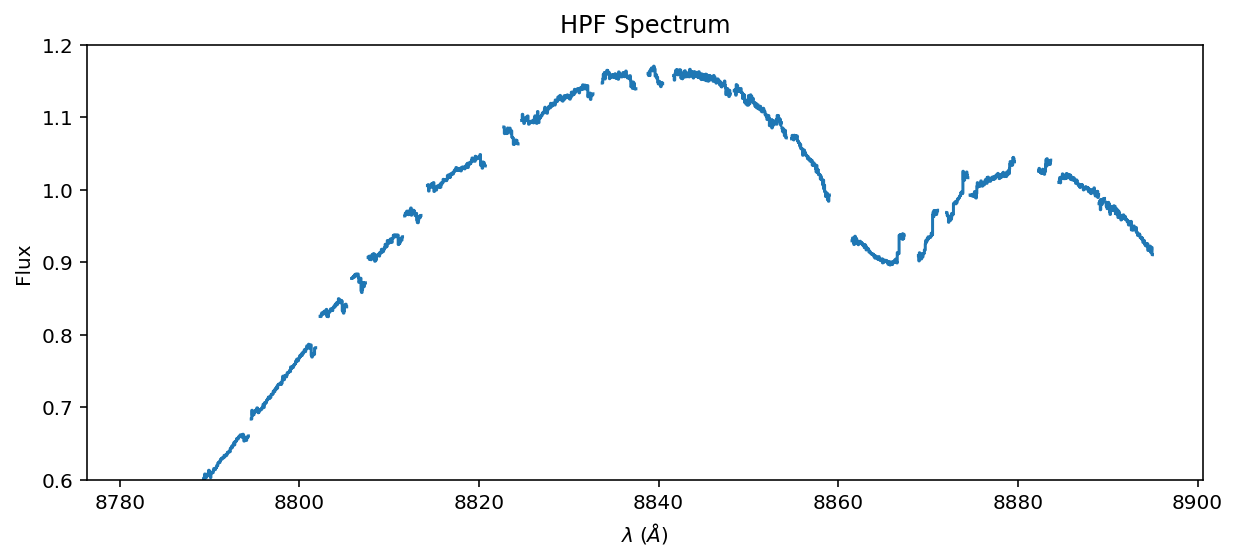

In [16]:
combined_spectrum.plot()